In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import glm

In [2]:
# Load the Data
df = pd.read_csv('AllLeagues_merged_match_data_2018_2023.csv')

In [3]:
# Data Cleaning - Drop Rows with Any Missing Values
# Convert 'GF' and 'GA' to numeric, handling errors
df['GF'] = pd.to_numeric(df['GF'], errors='coerce')
df['GA'] = pd.to_numeric(df['GA'], errors='coerce')

In [4]:
# Drop rows where critical data is missing (Result, GF, GA, Formation, Opp Formation)
# These are essential for the analysis, and dropping them is justified if their absence is random.
df = df.dropna(subset=['Result', 'GF', 'GA', 'Formation', 'Opp Formation', 'xG', 'xGA', 'Poss'])

print("\nAfter dropping rows with missing 'Result', 'GF', 'GA', 'Formation', 'Opp Formation', DataFrame Length:", len(df))
print("\nMissing Value Counts After Initial Cleaning:")
print(df.isnull().sum())


After dropping rows with missing 'Result', 'GF', 'GA', 'Formation', 'Opp Formation', DataFrame Length: 22672

Missing Value Counts After Initial Cleaning:
Date                 0
Time                 0
Comp                 0
Round                0
Day                  0
Venue                0
Result               0
GF                   0
GA                   0
Opponent             0
xG                   0
xGA                  0
Poss                 0
Attendance        5439
Captain              3
Formation            0
Opp Formation        0
Referee              0
Match Report         0
Notes            22117
Squad                0
dtype: int64


In [5]:
# Feature Engineering
# Create numeric Win/Loss/Draw columns
df['Win'] = df['Result'].apply(lambda x: 1 if x == 'W' else 0)
df['Loss'] = df['Result'].apply(lambda x: 1 if x == 'L' else 0)
df['Draw'] = df['Result'].apply(lambda x: 1 if x == 'D' else 0)

# Create additional features
df['Goal_Difference'] = df['GF'] - df['GA']
df['Total_Goals'] = df['GF'] + df['GA']
df['Points'] = df['Win'] * 3 + df['Draw'] * 1
df['Is_Home'] = df['Venue'].apply(lambda x: 1 if x == 'Home' else 0)
df['xG_Difference'] = df['xG'] - df['xGA']
df['xG_Ratio'] = df['xG'] / df['xGA']
df['Points_Per_Game'] = df['Points']

In [6]:
# Formation Cleaning (Crucial for Regression)
df['Formation_Clean'] = df['Formation'].str.replace('[^a-zA-Z0-9_]+', '', regex=True)

In [7]:
# Descriptive Statistics
print("\n----- 5. Descriptive Statistics -----")
descriptive_stats = df[['GF', 'GA', 'Poss', 'xG', 'xGA', 'Goal_Difference', 'Points']].describe()
print(descriptive_stats)


----- 5. Descriptive Statistics -----
                 GF            GA          Poss            xG           xGA  \
count  22672.000000  22672.000000  22672.000000  22672.000000  22672.000000   
mean       1.416417      1.334598     50.675812      1.389079      1.322358   
std        1.252189      1.214932     10.962584      0.802345      0.780015   
min        0.000000      0.000000     17.000000      0.000000      0.000000   
25%        0.000000      0.000000     43.000000      0.800000      0.700000   
50%        1.000000      1.000000     51.000000      1.300000      1.200000   
75%        2.000000      2.000000     59.000000      1.800000      1.800000   
max        9.000000      9.000000     83.000000      5.900000      5.900000   

       Goal_Difference        Points  
count     22672.000000  22672.000000  
mean          0.081819      1.425723  
std           1.829136      1.316972  
min          -9.000000      0.000000  
25%          -1.000000      0.000000  
50%           0


----- 6. Formation Frequency -----
Formation
4-2-3-1       5033
4-3-3         4118
4-4-2         2847
3-4-3         2386
3-5-2         2133
4-1-4-1       1160
3-4-1-2       1090
4-3-1-2        783
5-3-2          626
3-1-4-2        456
4-4-1-1        423
5-4-1          308
4-1-2-1-2◆     304
4-2-2-2        232
4-3-2-1        225
3-5-1-1        168
4-1-3-2        157
4-5-1          153
3-2-4-1         36
3-3-3-1         23
3-4-3◆          10
4-2-4-0          1
Name: count, dtype: int64


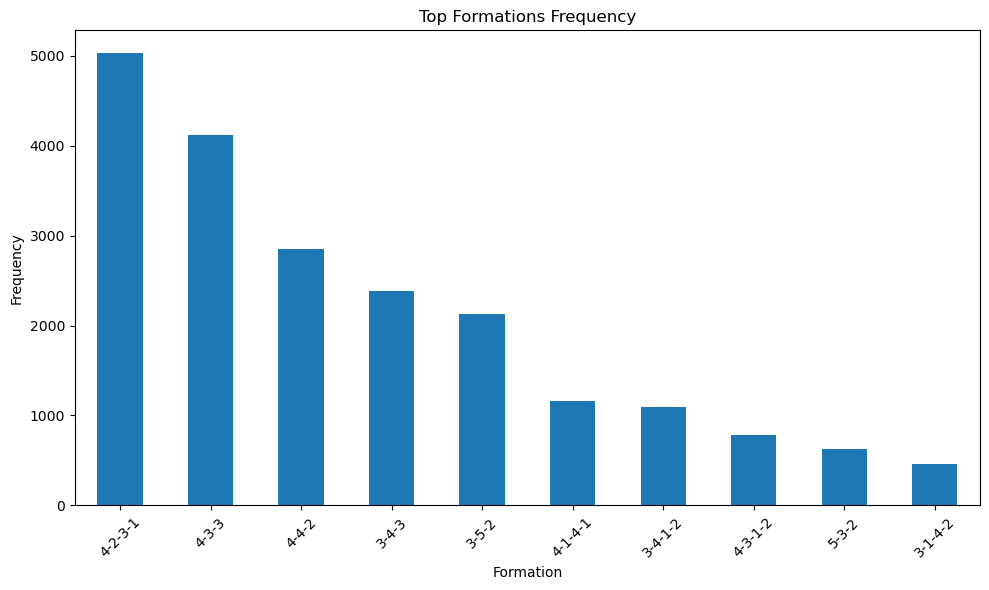

In [8]:
# Formation Frequency
print("\n----- 6. Formation Frequency -----")
formation_counts = df['Formation'].value_counts()
print(formation_counts)

# Visualization: Bar plot of formation frequency (Top N)
top_n = 10  # Display top 10 formations, adjust as needed
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
formation_counts[:top_n].plot(kind='bar')
plt.title('Top Formations Frequency')
plt.xlabel('Formation')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


----- 7. Win Rates by Formation -----
Formation
3-4-3◆        0.700000
3-2-4-1       0.638889
3-3-3-1       0.608696
4-3-3         0.461632
4-2-2-2       0.439655
4-2-3-1       0.419432
4-1-2-1-2◆    0.401316
3-4-3         0.391450
4-1-3-2       0.388535
3-4-1-2       0.387156
3-5-2         0.364744
4-4-2         0.358623
4-3-1-2       0.355045
4-1-4-1       0.340517
3-5-1-1       0.333333
4-4-1-1       0.328605
3-1-4-2       0.324561
4-3-2-1       0.280000
5-3-2         0.268371
5-4-1         0.233766
4-5-1         0.209150
4-2-4-0       0.000000
Name: Win, dtype: float64


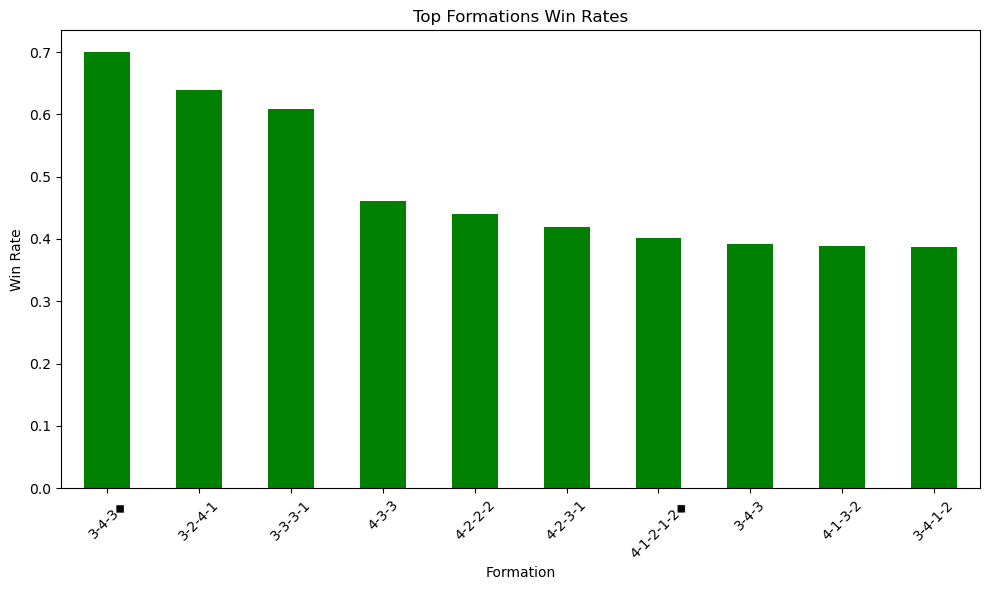

In [9]:
# Win Rates by Formation
print("\n----- 7. Win Rates by Formation -----")
win_rates = df.groupby('Formation')['Win'].mean().sort_values(ascending=False)
print(win_rates)

# Visualization: Bar plot of win rates (Top N)
top_n = 10  # Adjust as needed
plt.figure(figsize=(10, 6))
win_rates[:top_n].plot(kind='bar', color='green')
plt.title('Top Formations Win Rates')
plt.xlabel('Formation')
plt.ylabel('Win Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

xG vs. Actual Goals by Formation:
     Formation        xG        GF  Conversion_Efficiency
2      3-3-3-1  1.408696  1.913043               1.358025
1      3-2-4-1  2.230556  2.500000               1.120797
11     4-2-2-2  1.586638  1.754310               1.105678
21       5-4-1  0.966234  1.045455               1.081989
6      3-5-1-1  1.163690  1.226190               1.053708
8   4-1-2-1-2◆  1.373026  1.440789               1.049353
16       4-3-3  1.513162  1.569694               1.037360
12     4-2-3-1  1.463839  1.516988               1.036308
20       5-3-2  1.105112  1.134185               1.026308
15     4-3-2-1  1.172000  1.195556               1.020099
4        3-4-3  1.397024  1.415339               1.013110
18       4-4-2  1.289392  1.296101               1.005203
3      3-4-1-2  1.461376  1.467890               1.004457
19       4-5-1  1.026797  1.026144               0.999363
7        3-5-2  1.317440  1.310361               0.994627
14     4-3-1-2  1.398978  1.385696    

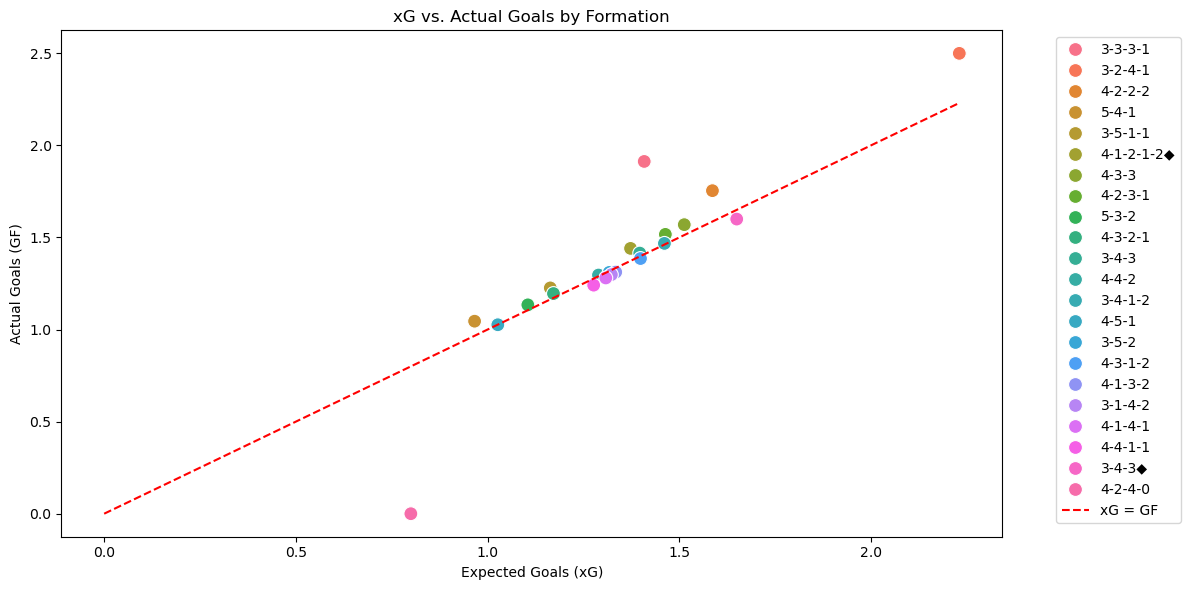

In [10]:
# xG vs. Actual Goals Analysis
xg_analysis = df.groupby('Formation').agg({
    'xG': 'mean',
    'GF': 'mean'
}).reset_index()

xg_analysis['Conversion_Efficiency'] = xg_analysis['GF'] / xg_analysis['xG']
xg_analysis = xg_analysis.sort_values('Conversion_Efficiency', ascending=False)

print("xG vs. Actual Goals by Formation:")
print(xg_analysis)

# Visualization for xG vs. Actual Goals
plt.figure(figsize=(12, 6))
sns.scatterplot(data=xg_analysis, x='xG', y='GF', hue='Formation', s=100)
plt.plot([0, xg_analysis['xG'].max()], [0, xg_analysis['xG'].max()], 'r--', label='xG = GF')
plt.title('xG vs. Actual Goals by Formation')
plt.xlabel('Expected Goals (xG)')
plt.ylabel('Actual Goals (GF)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


xGA vs. Actual Goals Conceded by Formation:
     Formation       xGA        GA  Defensive_Efficiency
5       3-4-3◆  1.190000  0.900000              1.322222
2      3-3-3-1  1.191304  0.956522              1.245455
1      3-2-4-1  0.916667  0.833333              1.100000
8   4-1-2-1-2◆  1.423026  1.328947              1.070792
14     4-3-1-2  1.411239  1.370370              1.029823
6      3-5-1-1  1.379167  1.345238              1.025221
16       4-3-3  1.224624  1.210539              1.011635
19       4-5-1  1.765359  1.751634              1.007836
7        3-5-2  1.354337  1.353024              1.000970
12     4-2-3-1  1.291536  1.303994              0.990446
18       4-4-2  1.334703  1.350896              0.988014
4        3-4-3  1.288600  1.305113              0.987347
9      4-1-3-2  1.324841  1.343949              0.985782
20       5-3-2  1.472204  1.503195              0.979384
10     4-1-4-1  1.349828  1.388793              0.971943
21       5-4-1  1.623701  1.675325         

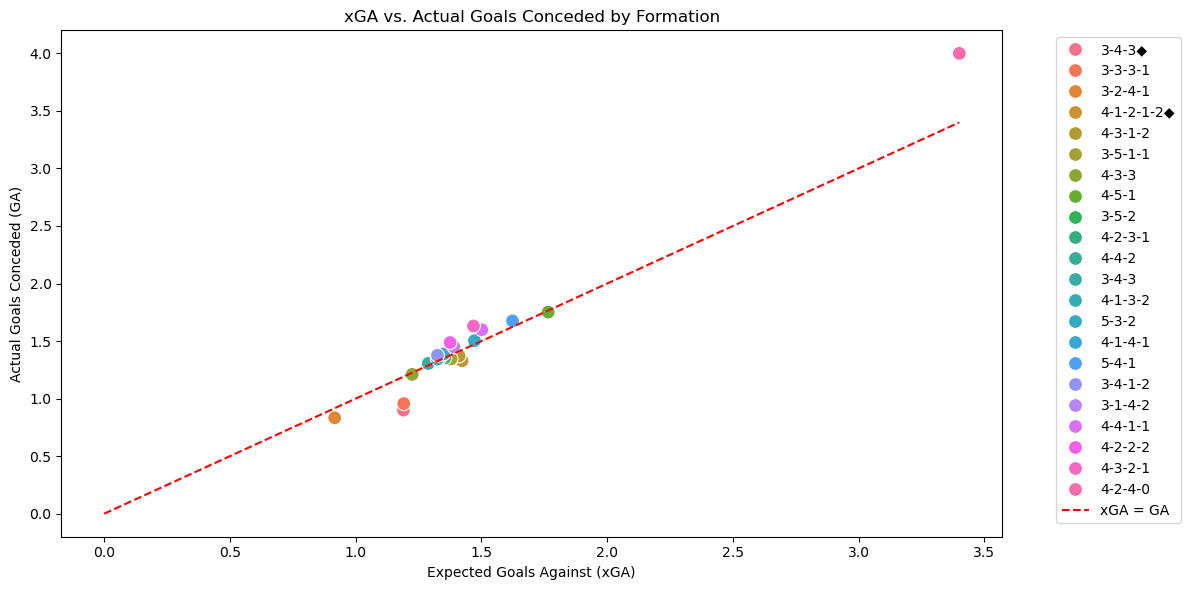

In [11]:
# xGA vs. Actual Goals Conceded Analysis
xga_analysis = df.groupby('Formation').agg({
    'xGA': 'mean',
    'GA': 'mean'
}).reset_index()

xga_analysis['Defensive_Efficiency'] = xga_analysis['xGA'] / xga_analysis['GA']
xga_analysis = xga_analysis.sort_values('Defensive_Efficiency', ascending=False)

print("\nxGA vs. Actual Goals Conceded by Formation:")
print(xga_analysis)

# Visualization for xGA vs. Actual Goals Conceded
plt.figure(figsize=(12, 6))
sns.scatterplot(data=xga_analysis, x='xGA', y='GA', hue='Formation', s=100)
plt.plot([0, xga_analysis['xGA'].max()], [0, xga_analysis['xGA'].max()], 'r--', label='xGA = GA')
plt.title('xGA vs. Actual Goals Conceded by Formation')
plt.xlabel('Expected Goals Against (xGA)')
plt.ylabel('Actual Goals Conceded (GA)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Pythagorean Win Theorem Analysis:
     Formation  Pythagorean_Win_Percentage  Actual_Win_Percentage  \
13     4-2-4-0                    0.000000               0.000000   
19       4-5-1                    0.255502               0.209150   
21       5-4-1                    0.280272               0.233766   
17     4-4-1-1                    0.376228               0.328605   
5       3-4-3◆                    0.759644               0.700000   
15     4-3-2-1                    0.349486               0.280000   
20       5-3-2                    0.362771               0.268371   
9      4-1-3-2                    0.488011               0.388535   
10     4-1-4-1                    0.459370               0.340517   
7        3-5-2                    0.483986               0.364744   
6      3-5-1-1                    0.453803               0.333333   
0      3-1-4-2                    0.445099               0.324561   
18       4-4-2                    0.479308               0.358623   


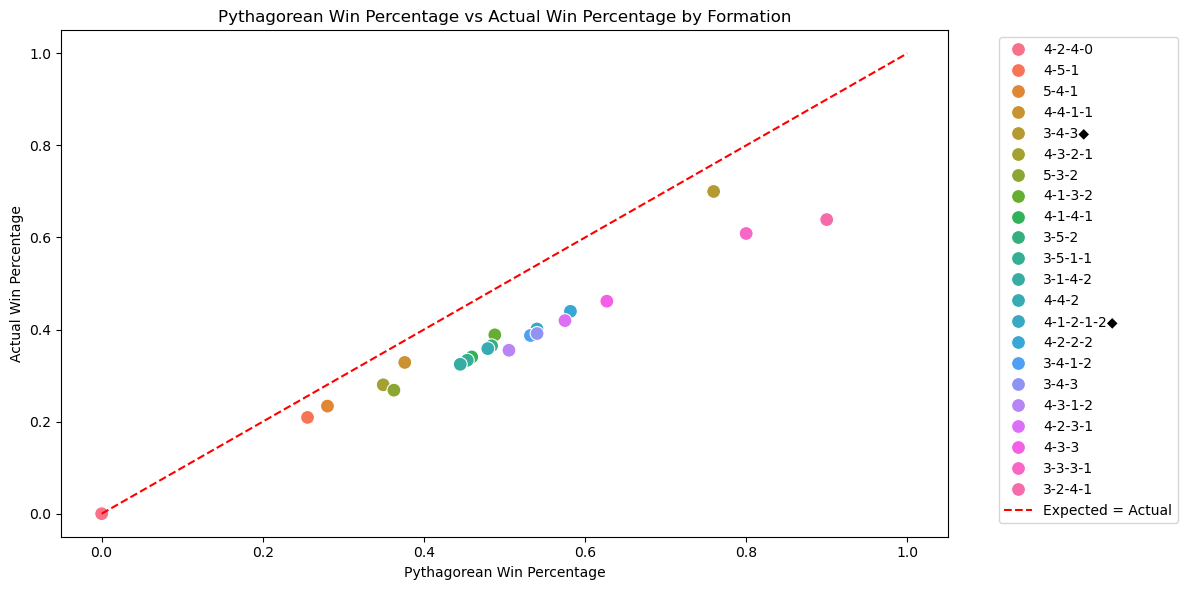

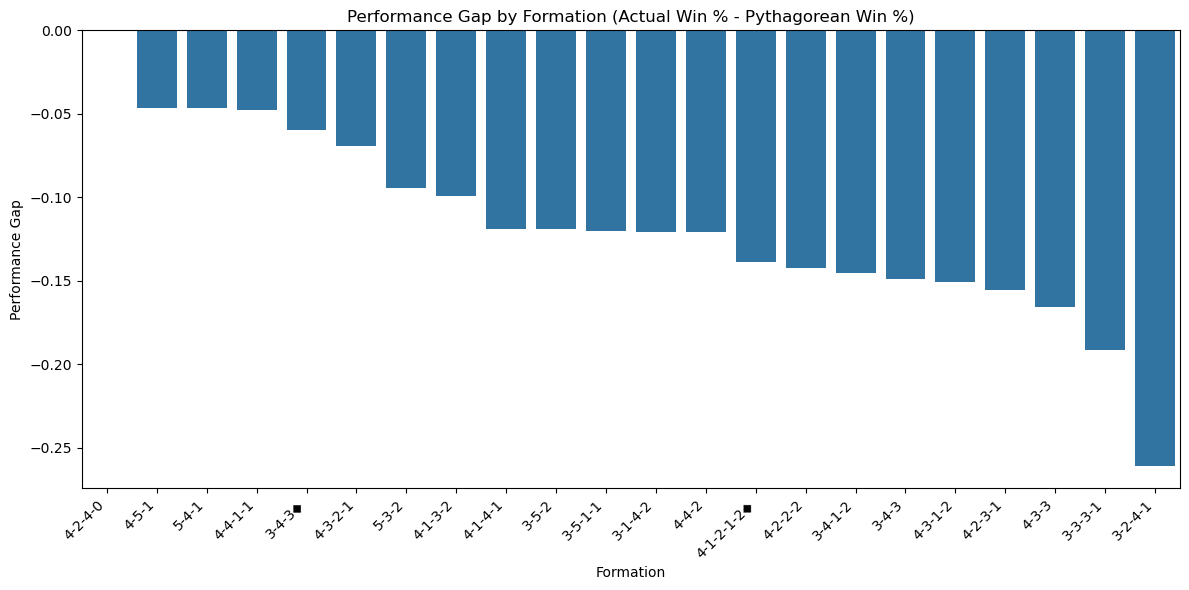

In [12]:
# Calculate Pythagorean Win Percentage and Actual Win Percentage for each formation
formation_stats = df.groupby('Formation').agg({
    'GF': 'sum',
    'GA': 'sum',
    'Win': 'sum',
    'Result': 'count'
}).reset_index()

formation_stats['Pythagorean_Win_Percentage'] = formation_stats['GF']**2 / (formation_stats['GF']**2 + formation_stats['GA']**2)
formation_stats['Actual_Win_Percentage'] = formation_stats['Win'] / formation_stats['Result']
formation_stats['Performance_Gap'] = formation_stats['Actual_Win_Percentage'] - formation_stats['Pythagorean_Win_Percentage']

# Sort by Performance Gap
formation_stats = formation_stats.sort_values('Performance_Gap', ascending=False)

print("Pythagorean Win Theorem Analysis:")
print(formation_stats[['Formation', 'Pythagorean_Win_Percentage', 'Actual_Win_Percentage', 'Performance_Gap']])

# Visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(data=formation_stats, x='Pythagorean_Win_Percentage', y='Actual_Win_Percentage', hue='Formation', s=100)
plt.plot([0, 1], [0, 1], 'r--', label='Expected = Actual')
plt.title('Pythagorean Win Percentage vs Actual Win Percentage by Formation')
plt.xlabel('Pythagorean Win Percentage')
plt.ylabel('Actual Win Percentage')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Bar plot of Performance Gap
plt.figure(figsize=(12, 6))
sns.barplot(x='Formation', y='Performance_Gap', data=formation_stats)
plt.title('Performance Gap by Formation (Actual Win % - Pythagorean Win %)')
plt.xlabel('Formation')
plt.ylabel('Performance Gap')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
import re

# Prepare the data
df['Result_Binary'] = df['Result'].apply(lambda x: 1 if x == 'W' else 0)
df['Is_Home'] = df['Venue'].apply(lambda x: 1 if x == 'Home' else 0)

# Create dummy variables for Formation and Opponent Formation
df = pd.get_dummies(df, columns=['Formation_Clean', 'Opp Formation'], drop_first=True)

# Function to clean column names
def clean_column_name(name):
    # Remove all non-alphanumeric characters and replace with underscore
    name = re.sub(r'\W+', '_', name)
    # Ensure the name starts with a letter
    if not name[0].isalpha():
        name = 'x_' + name
    return name

# Clean all column names
df.columns = [clean_column_name(col) for col in df.columns]

# Specify the formula
formation_vars = [col for col in df.columns if col.startswith('Formation_Clean_')]
opp_formation_vars = [col for col in df.columns if col.startswith('Opp_Formation_')]

formula = ('Result_Binary ~ Poss + Is_Home + ' + 
           ' + '.join(formation_vars) + 
           ' + ' + 
           ' + '.join(opp_formation_vars))

# Fit the logistic regression model
model = glm(formula=formula, data=df, family=sm.families.Binomial()).fit()

# Print the summary
print(model.summary())

# Calculate and print odds ratios
odds_ratios = pd.DataFrame({
    'Odds Ratio': np.exp(model.params),
    'Lower CI': np.exp(model.conf_int()[0]),
    'Upper CI': np.exp(model.conf_int()[1])
})
print("\nOdds Ratios:")
print(odds_ratios)


                 Generalized Linear Model Regression Results                  
Dep. Variable:          Result_Binary   No. Observations:                22672
Model:                            GLM   Df Residuals:                    22629
Model Family:                Binomial   Df Model:                           42
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14756.
Date:                Tue, 04 Mar 2025   Deviance:                       29512.
Time:                        00:40:04   Pearson chi2:                 2.27e+04
No. Iterations:                    19   Pseudo R-squ. (CS):            0.03537
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


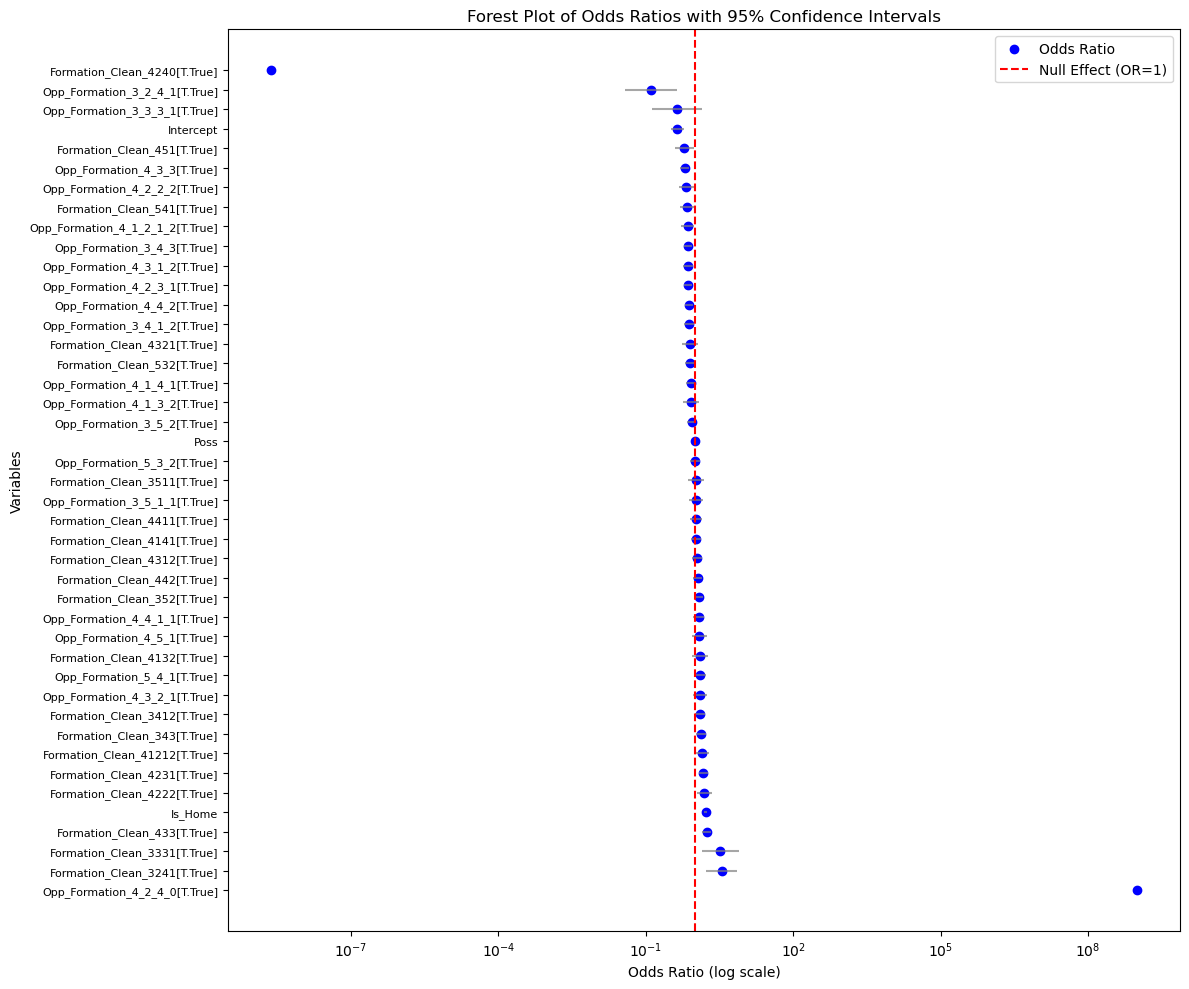

In [14]:
# Sort data by Odds Ratio for better visualization
odds_ratios = odds_ratios.sort_values(by='Odds Ratio', ascending=False)

# Create the plot
plt.figure(figsize=(12, 10))  # Increased figure size for better readability

# Plot odds ratios as points
plt.scatter(odds_ratios['Odds Ratio'], range(len(odds_ratios)), color='blue', label='Odds Ratio')

# Add horizontal error bars for confidence intervals
plt.hlines(y=range(len(odds_ratios)), xmin=odds_ratios['Lower CI'], xmax=odds_ratios['Upper CI'], color='gray', alpha=0.7)

# Add a vertical line at Odds Ratio = 1 (null effect)
plt.axvline(x=1, color='red', linestyle='--', label='Null Effect (OR=1)')

# Customize the plot
plt.yticks(range(len(odds_ratios)), odds_ratios.index, fontsize=8)  # Use index as labels
plt.xscale('log')  # Use log scale for x-axis
plt.xlabel('Odds Ratio (log scale)')
plt.ylabel('Variables')
plt.title('Forest Plot of Odds Ratios with 95% Confidence Intervals')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
pip install linearmodels

Note: you may need to restart the kernel to use updated packages.


In [16]:
import statsmodels.api as sm
from linearmodels import PanelOLS

# Prepare the data
df = df.set_index(['Squad', df.index])  # Set Squad and original index as MultiIndex

# Prepare the dependent variable
y = df['Result_Binary']

# Prepare the independent variables
X = df[['Poss', 'Is_Home'] + 
       [col for col in df.columns if col.startswith('Formation_Clean_')] +
       [col for col in df.columns if col.startswith('Opp_Formation_')]]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the fixed effects model
model = PanelOLS(y, X, entity_effects=True)
results = model.fit()

# Print the summary
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:          Result_Binary   R-squared:                        0.0327
Estimator:                   PanelOLS   R-squared (Between):             -0.1961
No. Observations:               22672   R-squared (Within):               0.0327
Date:                Tue, Mar 04 2025   R-squared (Overall):              0.0279
Time:                        00:40:08   Log-likelihood                 -1.49e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      18.134
Entities:                         109   P-value                           0.0000
Avg Obs:                       208.00   Distribution:                F(42,22521)
Min Obs:                       34.000                                           
Max Obs:                       5558.0   F-statistic (robust):             18.134
                            

In [17]:
df.columns

Index(['Date', 'Time', 'Comp', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA',
       'Opponent', 'xG', 'xGA', 'Poss', 'Attendance', 'Captain', 'Formation',
       'Referee', 'Match_Report', 'Notes', 'Win', 'Loss', 'Draw',
       'Goal_Difference', 'Total_Goals', 'Points', 'Is_Home', 'xG_Difference',
       'xG_Ratio', 'Points_Per_Game', 'Result_Binary', 'Formation_Clean_3241',
       'Formation_Clean_3331', 'Formation_Clean_3412', 'Formation_Clean_343',
       'Formation_Clean_3511', 'Formation_Clean_352', 'Formation_Clean_41212',
       'Formation_Clean_4132', 'Formation_Clean_4141', 'Formation_Clean_4222',
       'Formation_Clean_4231', 'Formation_Clean_4240', 'Formation_Clean_4312',
       'Formation_Clean_4321', 'Formation_Clean_433', 'Formation_Clean_4411',
       'Formation_Clean_442', 'Formation_Clean_451', 'Formation_Clean_532',
       'Formation_Clean_541', 'Opp_Formation_3_2_4_1', 'Opp_Formation_3_3_3_1',
       'Opp_Formation_3_4_1_2', 'Opp_Formation_3_4_3', 'Opp_Formation_3